In [8]:
from datetime import datetime, timedelta
import datetime
import pandas as pd
import requests
import pytz
from timezonefinder import TimezoneFinder
from io import StringIO
import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from astral import LocationInfo
from astral.sun import sun
from astral.sun import elevation
from matplotlib import rcParams

In [2]:
# Load credentials
with open('/Users/vinusooriyaarachchi/gitHubRepos/mints-aq-reports/notebooks/julia/plot-demo/credentials.json') as f:
    creds = json.load(f)

token = creds["token"]
org = creds["orgname"]
bucket = creds["bucket"]
url = f"http://mdash.circ.utdallas.edu:8086/api/v2/query?org={org}"

headers = {
    "Authorization": f"Token {token}",
    "Accept": "application/csv",
    "Content-type": "application/vnd.flux"
}

# Set the initial datetime and node
d = datetime.datetime(2024, 7, 1, 0, 0, 0)
node = "vaLo Node 01"

# Calculate the start and end times
dstart = d - datetime.timedelta(minutes=25)
dend = d + datetime.timedelta(days=1, minutes=25)

# InfluxDB query
query_gps = f"""
from(bucket: "SharedAirDFW")
  |> range(start: time(v: "{d.isoformat()}Z"), stop: time(v: "{(d + datetime.timedelta(days=1)).isoformat()}Z"))
  |> filter(fn: (r) => r["device_name"] == "{node}")
  |> filter(fn: (r) => r["_measurement"] == "GPSGPGGA2")
  |> filter(fn: (r) => r["_field"] == "latitudeCoordinate" or r["_field"] == "longitudeCoordinate" or r["_field"] == "altitude")
  |> aggregateWindow(every: 1m, fn: mean, createEmpty: true)
  |> pivot(rowKey:["_time"], columnKey: ["_field"], valueColumn: "_value")
  |> keep(columns: ["_time", "latitudeCoordinate", "longitudeCoordinate", "altitude"])
"""

# Post the query to InfluxDB
resp = requests.post(url, headers=headers, data=query_gps)

# Read the response into a DataFrame
df = pd.read_csv(StringIO(resp.text))

# Drop unnecessary columns and missing values
df.drop(columns=['result', 'table', '_time','Unnamed: 0'], inplace=True)
df.dropna(inplace=True)


In [3]:
pos = {
    'lat': df['latitudeCoordinate'].mean(),
    'lon': df['longitudeCoordinate'].mean(),
    'alt': df['altitude'].mean()
}

# Get the timezone at the given latitude and longitude
tf = TimezoneFinder()
tzone = tf.timezone_at(lat=pos['lat'], lng=pos['lon'])

# Set the timezone for the datetime
d = pytz.timezone(tzone).localize(d)
dstart = d - datetime.timedelta(minutes=25)
dend = d + datetime.timedelta(days=1, minutes=25)

# Set up the theme for plotting
sns.set_theme(style="whitegrid")
plt.rcParams.update({
    'figure.figsize': (10, 6),
    'axes.labelsize': 22,
    'xtick.labelsize': 20,
    'ytick.labelsize': 20,
    'axes.titlesize': 25,
    'legend.fontsize': 20
})

# Function to plot data
def plot_data(df):
    fig, ax = plt.subplots()
    sns.lineplot(data=df, x='datetime', y='value', ax=ax)
    ax.set_title('Plot Title')
    ax.set_xlabel('X Axis Label')
    ax.set_ylabel('Y Axis Label')
    plt.show()

In [4]:
def process_df(response, tzone, d):
    df = pd.read_csv(StringIO(response.text))
    df.drop(columns=['result', 'table','Unnamed: 0'], inplace=True)
    df.dropna(inplace=True)
    df['datetime'] = pd.to_datetime(df['_time'])
    df['datetime'] = df['datetime'].dt.tz_convert(tzone)
    df.drop(columns=['_time'], inplace=True)
    return df


In [5]:
# Define the start and end times for the queries
dstart_str = dstart.isoformat()
dend_str = dend.isoformat()

# Queries
query_ips = f"""
from(bucket: "SharedAirDFW")
  |> range(start: time(v: "{dstart_str}"), stop: time(v: "{dend_str}"))
  |> filter(fn: (r) => r["device_name"] == "{node}")
  |> filter(fn: (r) => r["_measurement"] == "IPS7100")
  |> filter(fn: (r) => r["_field"] == "pm0_1" or r["_field"] == "pm0_3" or r["_field"] == "pm0_5" or r["_field"] == "pm1_0" or r["_field"] == "pm2_5" or r["_field"] == "pm5_0" or r["_field"] == "pm10_0")
  |> aggregateWindow(every: 1m, period: 5m, offset:-150s, fn: mean, createEmpty: true)
  |> pivot(rowKey:["_time"], columnKey: ["_field"], valueColumn: "_value")
  |> keep(columns: ["_time", "pm0_1", "pm0_3", "pm0_5", "pm1_0", "pm2_5", "pm5_0", "pm10_0"])

  
"""

query_bme = f"""
from(bucket: "SharedAirDFW")
  |> range(start: time(v: "{dstart_str}"), stop: time(v: "{dend_str}"))
  |> filter(fn: (r) => r["device_name"] == "{node}")
  |> filter(fn: (r) => r["_measurement"] == "BME280V2")
  |> filter(fn: (r) => r["_field"] == "temperature" or r["_field"] == "pressure" or r["_field"] == "humidity" or r["_field"] == "dewPoint")
  |> aggregateWindow(every: 1m, period: 5m, offset:-150s, fn: mean, createEmpty: true)
  |> pivot(rowKey:["_time"], columnKey: ["_field"], valueColumn: "_value")
  |> keep(columns: ["_time", "temperature", "pressure", "humidity", "dewPoint"])
"""

query_rg15 = f"""
from(bucket: "SharedAirDFW")
  |> range(start: time(v: "{dstart_str}"), stop: time(v: "{dend_str}"))
  |> filter(fn: (r) => r["device_name"] == "{node}")
  |> filter(fn: (r) => r["_measurement"] == "RG15")
  |> filter(fn: (r) => r["_field"] == "rainPerInterval" or r["_field"] == "accumulation")
  |> aggregateWindow(every: 1m, period: 5m, offset:-150s, fn: mean, createEmpty: true)
  |> pivot(rowKey:["_time"], columnKey: ["_field"], valueColumn: "_value")
  |> keep(columns: ["_time", "rainPerInterval"])
"""

query_scd30 = """
from(bucket: "SharedAirDFW")
  |> range(start: time(v: "{dstart_str}"), stop: time(v: "{dend_str}"))
  |> filter(fn: (r) => r["device_name"] == "{node}")
  |> filter(fn: (r) => r["_measurement"] == "SCD30V2")
  |> filter(fn: (r) => r["_field"] == "co2" or r["_field"] == "temperature")
  |> aggregateWindow(every: 1m, period: 5m, offset:-150s,  fn: mean, createEmpty: true)
  |> pivot(rowKey:["_time"], columnKey: ["_field"], valueColumn: "_value")
  |> keep(columns: ["_time", "co2"])
"""   


# Send requests and process data
resp_ips = requests.post(url, headers=headers, data=query_ips)
df_ips = process_df(resp_ips, tzone, d)

resp_bme = requests.post(url, headers=headers, data=query_bme)
df_bme = process_df(resp_bme, tzone, d)

resp_rg15 = requests.post(url, headers=headers, data=query_rg15)
df_rg = process_df(resp_rg15, tzone, d)

#resp_scd30 = requests.post(url, headers=headers, data=query_scd30)
#df_scd = process_df(resp_scd30, tzone, d)

df = pd.merge(df_ips, df_bme, on='datetime', how='left')
df = pd.merge(df, df_rg, on='datetime', how='left')
#df = pd.merge(df, df_scd, on='datetime', how='left')



In [6]:
location = LocationInfo(latitude=pos['lat'], longitude=pos['lon'], timezone='UTC')

def calculate_solar_elevation(timestamp):
    date = timestamp.to_pydatetime()
    return elevation(location.observer, date)

df['sol_el'] = df['datetime'].apply(calculate_solar_elevation)
df['sol_zenith'] = 90 - df['sol_el']


df['rainPerInterval'] = df['rainPerInterval'].fillna(0.0).replace(np.nan, 0.0)



In [7]:
df['dt'] = [(v - df.datetime[0]).value / (60*60*10000000) for v in df.datetime]

/var/folders/77/p3609gd54ksfgsjngpspx22m0000gn/T/ipykernel_37047/2895928709.py:101: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(pad=figure_padding)


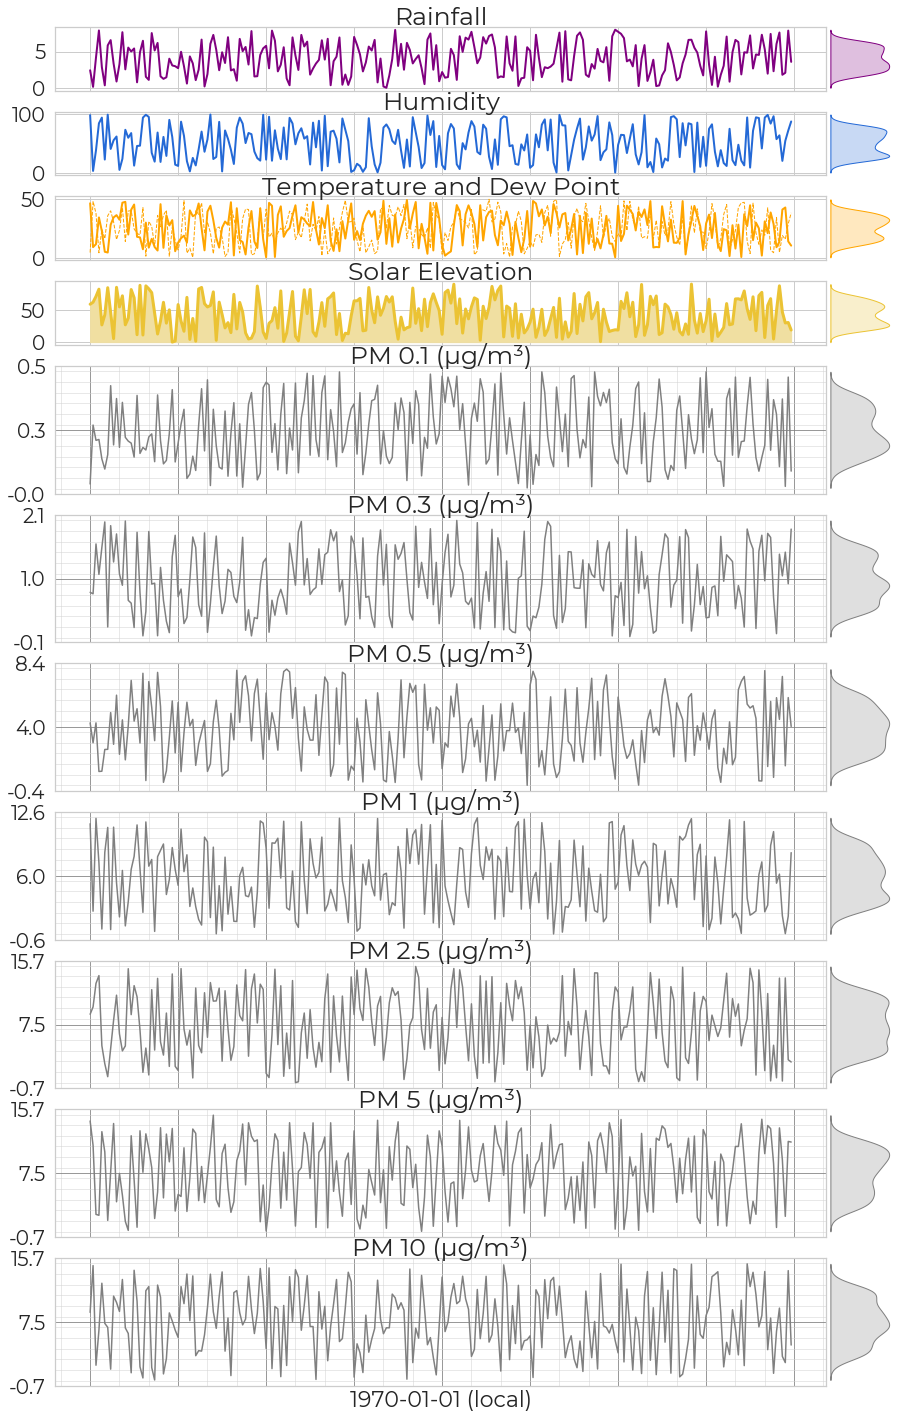

In [9]:


# Get Montserrat
rcParams['font.family'] = 'Montserrat'

# Dummy dataframe 
df = pd.DataFrame({
    'dt': np.arange(0, 24, 0.1),
    'sol_el': np.random.uniform(0, 90, 240),
    'temperature': np.random.uniform(0, 50, 240),
    'dewPoint': np.random.uniform(0, 50, 240),
    'humidity': np.random.uniform(0, 100, 240),
    'rainPerInterval': np.random.uniform(0, 8, 240),
    'pm0_1': np.random.uniform(0, 0.5, 240),
    'pm0_3': np.random.uniform(0, 2, 240),
    'pm0_5': np.random.uniform(0, 8, 240),
    'pm1_0': np.random.uniform(0, 12, 240),
    'pm2_5': np.random.uniform(0, 15, 240),
    'pm5_0': np.random.uniform(0, 15, 240),
    'pm10_0': np.random.uniform(0, 15, 240)
})

# Define colors
cline = "#ebc334"
cfill = "#f0dfa1"
crain = "#2469d6"

# Create figure and grid layout
fig, axes = plt.subplots(nrows=11, ncols=2, figsize=(15, 25), 
                         gridspec_kw={'width_ratios': [1, 0.08],'height_ratios': [1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2], 'wspace': 0.01, 'hspace': 0.2})

# Axis settings
yticklabelsize = 20
xticklabelsize = 20
xlabelsize = 22
ylabelsize = 22
titlesize = 25
titlegap = 2
figure_padding = 30

# Function to set up axis
def setup_axis(ax, title, x_labels=False):
    ax.set_xticks(np.arange(0, 25, 3))
    ax.set_title(title, fontsize=titlesize, pad=titlegap)
    if x_labels:
        ax.set_xlabel(f'{pd.to_datetime(df["dt"]).dt.date[0]} (local)', fontsize=xlabelsize)
    else:
        ax.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)

# Plotting each variable
setup_axis(axes[0, 0], 'Rainfall')
axes[0, 0].plot(df['dt'], df['rainPerInterval'], color='purple', linewidth=2)
sns.kdeplot(df['rainPerInterval'], ax=axes[0, 1], color='purple', fill=True,y=df['rainPerInterval'])
axes[0, 1].axis('off')

setup_axis(axes[1, 0], 'Humidity')
axes[1, 0].plot(df['dt'], df['humidity'], color=crain, linewidth=2)
sns.kdeplot(df['humidity'], ax=axes[1, 1], color=crain, fill=True,y=df['humidity'])
axes[1, 1].axis('off')

setup_axis(axes[2, 0], 'Temperature and Dew Point')
axes[2, 0].plot(df['dt'], df['temperature'], color='orange', linewidth=2, label='Temperature')
axes[2, 0].plot(df['dt'], df['dewPoint'], color='orange', linestyle='dashed', linewidth=1, label='Dew Point')
sns.kdeplot(df['temperature'], ax=axes[2, 1], color='orange', fill=True,y=df['temperature'])
axes[2, 1].axis('off')

setup_axis(axes[3, 0], 'Solar Elevation')
axes[3, 0].plot(df['dt'], df['sol_el'], color=cline, linewidth=3)
axes[3, 0].fill_between(df['dt'], 0, df['sol_el'], color=cfill)
sns.kdeplot(df['sol_el'], ax=axes[3, 1], color=cline, fill=True,y=df['sol_el'])
axes[3, 1].axis('off')

# Function to plot PM data with specified y-ticks and grid
def plot_pm(ax, ax_hist, pm_data, title):
    setup_axis(ax, title)
    ax.plot(df['dt'], pm_data, color='gray')
    sns.kdeplot(pm_data, ax=ax_hist, color='gray', fill=True,y=pm_data)
    ax_hist.axis('off')
    # Set y-ticks to ensure at least 6 vertical cells and label middle, min, and max
    min_val, max_val = ax.get_ylim()
    mid_val = (min_val + max_val) / 2
    ax.set_yticks([min_val, mid_val, max_val])
    ax.set_yticklabels([f'{min_val:.1f}', f'{mid_val:.1f}', f'{max_val:.1f}'], fontsize=yticklabelsize)
    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: '{:.1f}'.format(x)))
    # Set minor ticks for sub-grid on both axes
    ax.yaxis.set_minor_locator(plt.MultipleLocator((max_val - min_val) / 12))
    ax.xaxis.set_minor_locator(plt.MultipleLocator(1))
    ax.grid(True, which='major', axis='both', linewidth=0.8, color='grey')  # Darker main grid lines
    ax.grid(True, which='minor', axis='both', color='lightgrey', linewidth=0.5)  # Lighter minor grid lines

plot_pm(axes[4, 0], axes[4, 1], df['pm0_1'], 'PM 0.1 (μg/m³)')
plot_pm(axes[5, 0], axes[5, 1], df['pm0_3'], 'PM 0.3 (μg/m³)')
plot_pm(axes[6, 0], axes[6, 1], df['pm0_5'], 'PM 0.5 (μg/m³)')
plot_pm(axes[7, 0], axes[7, 1], df['pm1_0'], 'PM 1 (μg/m³)')
plot_pm(axes[8, 0], axes[8, 1], df['pm2_5'], 'PM 2.5 (μg/m³)')
plot_pm(axes[9, 0], axes[9, 1], df['pm5_0'], 'PM 5 (μg/m³)')
plot_pm(axes[10, 0], axes[10, 1], df['pm10_0'], 'PM 10 (μg/m³)')

# Adjust layout
for ax in axes[:, 0]:
    ax.set_ylabel('')
axes[10, 0].set_xlabel(f'{pd.to_datetime(df["dt"]).dt.date[0]} (local)', fontsize=xlabelsize)
plt.tight_layout(pad=figure_padding)
plt.show()
